[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/multimodal_ai/blob/main/image_captioning.ipynb)

In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
from PIL import Image  # Load img
import statistics
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

# to download dataset from kaggle
import requests
import zipfile
from io import BytesIO

In [2]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Dataset**



In [3]:
def kaggle_dataset_download(api_key,
                            your_username = 'sarveshkhetan',
                            dataset_owner_id = 'adityajn105',
                            dataset_name = 'flickr8k',
                            download_path = './Flickr8k'):

  os.makedirs(download_path, exist_ok=True)

  # Construct the API URL
  url = f'https://www.kaggle.com/api/v1/datasets/download/{dataset_owner_id}/{dataset_name}'

  # Make the request with authentication
  response = requests.get(url, headers={'Authorization': f'Basic {your_username}:{api_key}'})

  if response.status_code == 200:
      # Extract the zip file
      z = zipfile.ZipFile(BytesIO(response.content))
      z.extractall(download_path)
      print(f"Dataset '{dataset_owner_id}/{dataset_name}' has been downloaded to '{download_path}'")
  else:
      print(f"Failed to download dataset: {response.status_code} - {response.text}")

kaggle_dataset_download("3d4180e397e9ad0db78b7a9b78899db6")

Dataset 'adityajn105/flickr8k' has been downloaded to './Flickr8k'


In [4]:
class Vocabulary:

    def __init__(self):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        spacy_eng = spacy.load("en_core_web_sm")
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 #cause first 3 index are already taken by <PAD> <SOS> <EOS> <UNK>

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):

                # adding word to the dictionary with it's frequency
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                # if frequency of the word >=5 then adding it to ITOS and STOI
                # you can change this threshold frequency value of 5 to any other number
                if frequencies[word] == 5:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [5]:
class FlickrDataset(Dataset):

    def __init__(self):
        self.df = pd.read_csv("Flickr8k/captions.txt").head(500) # only using first 5000 rows of the dataframe cause it it a huge huge dataset
        self.transform = transforms.Compose([transforms.Resize((356, 356)),
                                                      transforms.RandomCrop((299, 299)),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary()
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        # loading 1 image and it's corresponding caption
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join("Flickr8k/Images", img_id)).convert("RGB")

        # performing transformation on the image
        img = self.transform(img)

        # tokenizing caption i.e. converting caption to numeric form '<SOS> I am Sarvesh <EOS>' => '<1> <243> <4904> <78> <2>'
        numericalized_caption = [self.vocab.stoi["<SOS>"]] # cause caption will start with special token <start of sentence> (SOS)
        numericalized_caption += self.vocab.numericalize(caption) # converting caption to numeric form
        numericalized_caption.append(self.vocab.stoi["<EOS>"]) # cause caption will end with special token <End of Sentence> (EOS)

        return img, torch.tensor(numericalized_caption)

In [6]:
class padding_function:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [7]:
dataset = FlickrDataset()

In [8]:
loader = DataLoader(
                        dataset = dataset,
                        batch_size = 32,
                        num_workers = 2,
                        shuffle = True,
                        pin_memory = True,
                        collate_fn = padding_function(pad_idx=0), # padding is important becuase all captions should be of same length
                        #pad index is 0 cause as defined above in stoi dictionary
                    )

# **Modelling**

In [37]:
class img_encoder(nn.Module):
    def __init__(self):
        super(img_encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 74 * 74, 256)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [38]:
class Language_Model(nn.Module):
    def __init__(self, vocab_size):
        super(Language_Model, self).__init__()
        self.embed = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(256, 256, 2)
        self.linear = nn.Linear(256, vocab_size)

    def forward(self, img_emb, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((img_emb.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [46]:
class Image_Conditioned_LM(nn.Module):
    def __init__(self, vocab_size):
        super(Image_Conditioned_LM, self).__init__()
        self.img_encoder = img_encoder()
        self.lm = Language_Model(vocab_size)

    def forward(self, images, captions):
        features = self.img_encoder(images)
        outputs = self.lm(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.img_encoder(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.lm.lstm(x, states)
                output = self.lm.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.lm.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# **Training**

In [47]:
model = Image_Conditioned_LM(len(dataset.vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [48]:
model.train()
step = 0

In [49]:
for epoch in range(1):

    for idx, (imgs, captions) in tqdm(enumerate(loader), total=len(loader), leave=False):

        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

# **Inference**

In [50]:
model.eval()

transform = transforms.Compose([transforms.Resize((299, 299)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_img = transform(Image.open("child.jpg").convert("RGB")).unsqueeze(0)

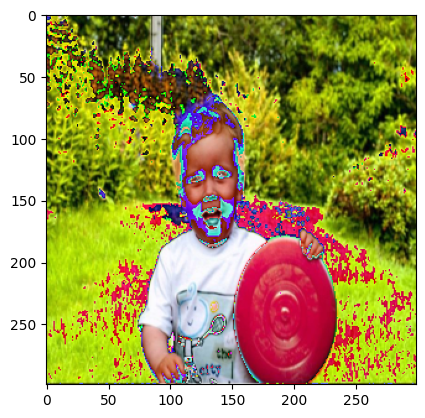

In [51]:
# Display the image using matplotlib
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(transforms.ToPILImage()(test_img.squeeze(0)))

In [52]:
print("Actual : Child holding red frisbee outdoors")
print("Predicted : "+ " ".join(model.caption_image(test_img.to(device), dataset.vocab)))

Actual : Child holding red frisbee outdoors
Predicted : <SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
